# Brunel 10K Neuron Network Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from numba import jit

%matplotlib inline

/home/nas/anaconda2/envs/cochlea/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#### Loading auryn weights

In [8]:
from scipy.io import mmread
aurynweightmatrix = mmread('../auryn/network.dat.0.0.wmat')

#### Loading NEST weights

In [2]:
# Loading nest weights
nestweights = np.loadtxt("../pyNest/PlasticSynapseWeights.txt")

#### Loading ANNarchy weights

In [19]:
# Loading nest weights
annarchyweights = np.loadtxt("../ANNarchy/plasticweights.txt")

#### Loading Brian2 weights

In [15]:
# Loading nest weights
brian2weights = np.loadtxt("../brian2/plasticweights.txt")

#### Loading Spike weights

In [3]:
prefile = "../Spike/Build/output/Synapses_NetworkPre.bin"
postfile = "../Spike/Build/output/Synapses_NetworkPost.bin"
weightfile = "../Spike/Build/output/Synapses_NetworkWeights.bin"


spike_network_df = pd.DataFrame(data = {"pre": np.fromfile(prefile, dtype=np.int32), "post": np.fromfile(postfile, dtype=np.int32), "weight": np.fromfile(weightfile, dtype=np.float32)})

In [4]:
mask = (spike_network_df["pre"] >= 0) & (spike_network_df["pre"] < 8000) & (spike_network_df["post"] >= 0) & (spike_network_df["post"] < 8000)
spikeweights = spike_network_df["weight"][mask]

### Plotting Weight Histograms after 20s of Simulation

In [30]:
data = [
    spikeweights.values*1000,
    annarchyweights.flatten(),
    aurynweightmatrix.data*1000,
#     brian2weights,
    nestweights
]

labels = [
    "Spike",
    "ANNarchy",
    "Auryn",
#     "Brian2",
    "Nest"
]

colors = [
    "red",
    "orange",
    "blue",
    "purple",
    "green"
]

([], <a list of 0 Text yticklabel objects>)

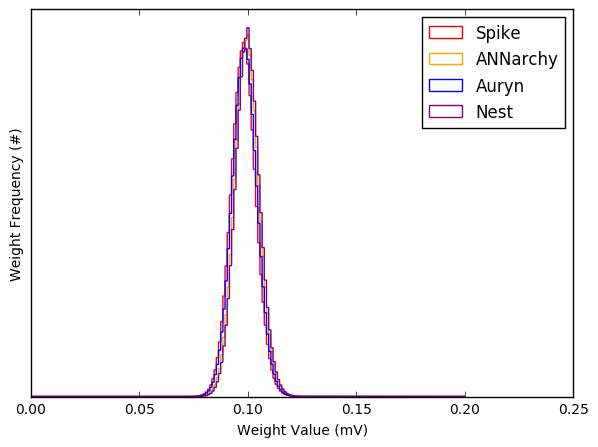

In [35]:
plt.figure(figsize=(7, 5))
ax = plt.subplot(1, 1, 1)
binvals = np.linspace(0.0,0.20,200)

for sim in range(len(data)):
    _ = ax.hist(data[sim], bins=binvals, color=colors[sim], label=labels[sim], histtype='step')

plt.legend()
plt.xlabel("Weight Value (mV)")
plt.ylabel("Weight Frequency (#)")
plt.yticks([])